A Simple Neural Net
===================

02/02/2020

For educational and discussion purposes with my son, I was searching around
for some Neural Network code to use.  I found this post https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795 and enjoyed how the code was described.  I thought it would serve as a good base as I wanted to use numpy and not just plain python as a starting point.  It was important to me to show that you can use linear algebra for the math and not just for loops all over the place.

In the end, it is a reasonable starting point, but it had a few issues that I had to fix along the way.  First, the update routine was indexing from 0, next he was missing a `convert_prob_into_class` function, there were many extra `;` in the code which makes me suspect it was translated from octave, but worst of all the initial random number weights were initialized into too small of a range which made training harder than it needed to be.  Only after fixing all of these things was I able to have success in training a simple XOR.

I also wanted to use only sigmoid activation functions since I know that should work from prior experiences

The code works, I can now follow the code pretty easily.  I'm still looking for a better description of back propagation.  Between the blog post, Andrew Ng's Backpropagation Algorithm discussion https://www.youtube.com/watch?v=x_Eamf8MHwU&list=PLLssT5z_DsK-h9vYZkQkYNWcItqhlRJLN&index=51 and Fei-Fei Li's Stanford course (Serena Yeung lecturing) https://www.youtube.com/watch?v=d14TUNcbn1k I was able to convince myself that the backpropagation code made some sense.  But, I'm not sure I could code it from scratch, though.

It would also be good to see if it can really accomplish the classification example claimed in the blog post.  


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

# Note: refactored the gradient code from the blogpost.  These are just the gradients.

# derivative of sigmoid is sig * (1 - sig)
# https://math.stackexchange.com/questions/78575/derivative-of-sigmoid-function-sigma-x-frac11e-x
def sigmoid_gradient(Z):
    sig = sigmoid(Z)
    dZ = sig * (1 - sig)
    return dZ

# derivative of relu is 1 when positive, 0 when negative
def relu_gradient(Z):
    dZ = np.ones(Z.shape)
    dZ[Z <= 0] = 0
    return dZ

def init_layers(seed, nn_architecture):
    """given a neural-net architecture, create a dictionary that describes its
    architecture & the parameters (Weights, Biases).  Use the seed value to
    control the randomness in order to reproduce the results."""
    np.random.seed(seed)
    nn = {
        "architecture": nn_architecture,
        "params": {}
    }
    nn_params = nn["params"]

    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        # BUGFIX?! original code multiplied all randn values
        # by 0.1 which REALLY makes the nets VERY HARD TO TRAIN.
        # TODO: should this vary by activation type?
        nn_params['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size)
        nn_params['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1)
    return nn

def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')
        
    return activation_func(Z_curr), Z_curr

def full_forward_propagation(X, nn):
    nn_params = nn["params"]
    nn_architecture = nn["architecture"]
    memory = {}
    A_curr = X
    
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        A_prev = A_curr
        
        activ_function_curr = layer["activation"]
        W_curr = nn_params["W" + str(layer_idx)]
        b_curr = nn_params["b" + str(layer_idx)]
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)
        
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    return A_curr, memory

def get_cost_value(Y_hat, Y):
    m = Y_hat.shape[1]
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return float(np.squeeze(cost))

def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

def convert_prob_into_class(probs):
    class_ = np.copy(probs)
    class_[probs > 0.5] = 1
    class_[probs <= 0.5] = 0
    return class_

def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    m = A_prev.shape[1]
    
    if activation is "relu":
        backward_gradient = relu_gradient
    elif activation is "sigmoid":
        backward_gradient = sigmoid_gradient
    else:
        raise Exception('Non-supported activation function')
    
    # dZ = dA * g'(Z) 
    dZ_curr = dA_curr * backward_gradient(Z_curr)
    # dW = 1/m * (dZ * A_prev)
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    # db = 1/m * dZ
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    # dA = W * dZ
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

def full_backward_propagation(Y_hat, Y, memory, nn):
    nn_params = nn["params"]
    nn_architecture = nn["architecture"]
    grads_values = {}
    #m = Y.shape[1]
    Y = Y.reshape(Y_hat.shape)
    
    # dA is dL/dY_hat from the binary crossentropy loss
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat))
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        layer_idx_curr = layer_idx_prev + 1
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        W_curr = nn_params["W" + str(layer_idx_curr)]
        b_curr = nn_params["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

def update(nn, grads_values, learning_rate):
    """update nn['params'] in place"""
    nn_params = nn["params"]
    for idx in range(len(nn["architecture"])):
        layer_idx = idx + 1 # changed to add this
        nn_params["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        nn_params["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]
    
def train(X, Y, nn, epochs, learning_rate):
    #breakpoint()
    cost_history = []
    accuracy_history = []
    
    for _ in range(epochs):
        Y_hat, cache = full_forward_propagation(X, nn)
        cost = get_cost_value(Y_hat, Y)
        cost_history.append(cost)
        accuracy = get_accuracy_value(Y_hat, Y)
        accuracy_history.append(accuracy)
        
        grads_values = full_backward_propagation(Y_hat, Y, cache, nn)
        update(nn, grads_values, learning_rate)
        
    return cost_history, accuracy_history

def predict(X, nn):
    Y_hat, _ = full_forward_propagation(X, nn)
    Y_hat_ = convert_prob_into_class(Y_hat)
    return Y_hat_, Y_hat

def train_and_check(X,Y,nn,epochs,learning_rate):
    fig = plt.figure(figsize=(9,3))
    cost_history, accuracy_history = train(X, Y, nn, epochs, learning_rate)
    plt.plot(cost_history,label="cost")
    plt.plot(accuracy_history,label="accuracy")
    plt.legend()
    plt.title("Training History")
    print(f"Test Predict:\nX = {X}\nY_predict = {predict(X, nn)}")

Test Predict:
X = [[0. 1.]]
Y_predict = (array([[0., 1.]]), array([[0.0308403 , 0.97843367]]))


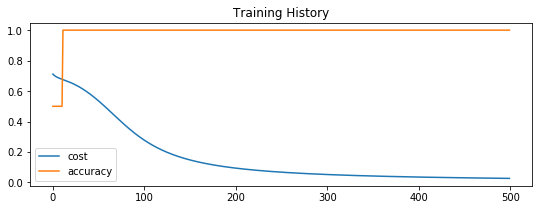

In [3]:
# random seed to allow us to repeat results. 
# I find that the seed DOES make a difference and sometimes
# we do not converge with different seeds (e.g. 2020)
seed = 1984 

# the learning rate
learning_rate = 0.2

# first, try a simple input-follows-output.
# if this doesn't work, nothing will.
nn = init_layers(seed, [
    {"input_dim": 1, "output_dim": 1, "activation": "sigmoid"},
    {"input_dim": 1, "output_dim": 1, "activation": "sigmoid"},
])
X = np.array([[0.0],[1.0]]).T
Y = np.array([[0.0],[1.0]]).T
epochs = 500
learning_rate = 0.5
train_and_check(X,Y,nn,epochs,learning_rate)

Test Predict:
X = [[0. 0. 1. 1.]
 [0. 1. 0. 1.]]
Y_predict = (array([[0., 1., 1., 1.]]), array([[0.02131924, 0.99860627, 0.9986432 , 0.99999996]]))


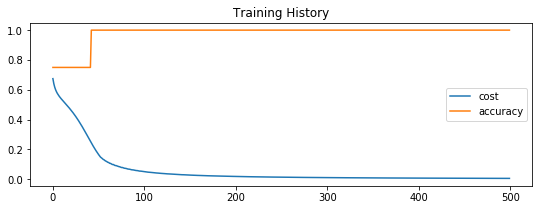

In [4]:
# relu/sigmoid OR gate
nn = init_layers(seed, [
    {"input_dim": 2, "output_dim": 2, "activation": "relu"},
    {"input_dim": 2, "output_dim": 1, "activation": "sigmoid"},
])
X = np.array([[0.0,0.0],[0.0,1.0],[1.0,0.0],[1.0,1.0]]).T
Y = np.array([[0.0],[1.0],[1.0],[1.0]]).T
epochs = 500
train_and_check(X,Y,nn,epochs,learning_rate)

Test Predict:
X = [[0. 0. 1. 1.]
 [0. 1. 0. 1.]]
Y_predict = (array([[0., 1., 1., 1.]]), array([[0.04103861, 0.98093511, 0.98086523, 0.99615731]]))


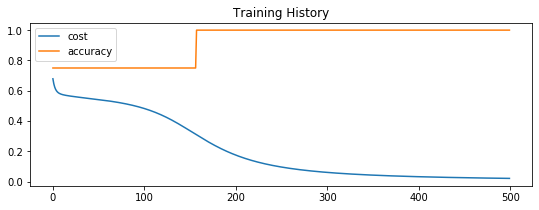

In [5]:
# full sigmoid OR gate
nn = init_layers(seed, [
    {"input_dim": 2, "output_dim": 2, "activation": "sigmoid"},
    {"input_dim": 2, "output_dim": 1, "activation": "sigmoid"},
])
X = np.array([[0.0,0.0],[0.0,1.0],[1.0,0.0],[1.0,1.0]]).T
Y = np.array([[0.0],[1.0],[1.0],[1.0]]).T
epochs = 500
learning_rate = 0.5
train_and_check(X,Y,nn,epochs,learning_rate)

Test Predict:
X = [[0. 0. 1. 1.]
 [0. 1. 0. 1.]]
Y_predict = (array([[0., 0., 0., 1.]]), array([[0.0014526 , 0.03835288, 0.04069027, 0.88026847]]))


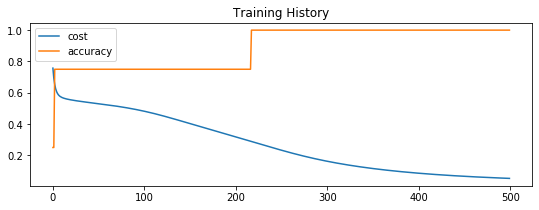

In [6]:
# full sigmoid AND gate
nn = init_layers(seed, [
    {"input_dim": 2, "output_dim": 2, "activation": "sigmoid"},
    {"input_dim": 2, "output_dim": 1, "activation": "sigmoid"},
])
X = np.array([[0.0,0.0],[0.0,1.0],[1.0,0.0],[1.0,1.0]]).T
Y = np.array([[0.0],[0.0],[0.0],[1.0]]).T
epochs = 500
learning_rate = 0.5
train_and_check(X,Y,nn,epochs,learning_rate)

Test Predict:
X = [[0. 0. 1. 1.]
 [0. 1. 0. 1.]]
Y_predict = (array([[0., 1., 1., 0.]]), array([[0.00491267, 0.99483899, 0.99483886, 0.00769975]]))


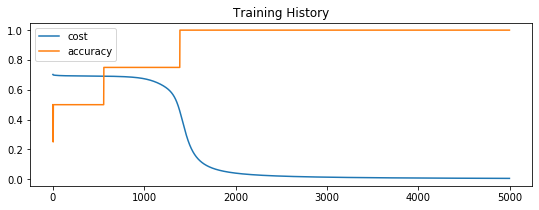

In [7]:
# now, the real test--a full sigmoid XOR gate
# Note that there are 3 layers in our neural architecture:
# an implied input layer, a hidden layer with 2 units and the output layer.
# So, there is enough here to solve for an XOR
seed = 1984
nn = init_layers(seed, [
    {"input_dim": 2, "output_dim": 2, "activation": "sigmoid"},
    {"input_dim": 2, "output_dim": 1, "activation": "sigmoid"},
])
X = np.array([[0.0,0.0],[0.0,1.0],[1.0,0.0],[1.0,1.0]]).T
Y = np.array([[0.0],[1.0],[1.0],[0.0]]).T
epochs = 5000 # Note the much longer training time
learning_rate = 0.5
train_and_check(X,Y,nn,epochs,learning_rate)

Test Predict:
X = [[0. 1.]]
Y_predict = (array([[0., 1.]]), array([[0.04380136, 0.96881675]]))


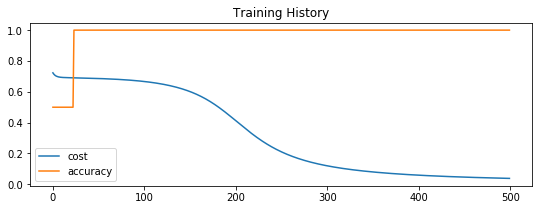

In [8]:
# Just to show that the code works for some more complicated nets, lets
# try a hidden layer output-follows-input
nn = init_layers(seed, [
    {"input_dim": 1, "output_dim": 1, "activation": "sigmoid"},
    {"input_dim": 1, "output_dim": 1, "activation": "sigmoid"},
    {"input_dim": 1, "output_dim": 1, "activation": "sigmoid"},
])
X = np.array([[0.0],[1.0]]).T
Y = np.array([[0.0],[1.0]]).T
epochs = 500
learning_rate = 0.5
train_and_check(X,Y,nn,epochs,learning_rate)

Test Predict:
X = [[0. 0. 1. 1.]
 [0. 1. 0. 1.]]
Y_predict = (array([[0., 0., 0., 1.]]), array([[0.01038464, 0.02441764, 0.02448443, 0.92294489]]))


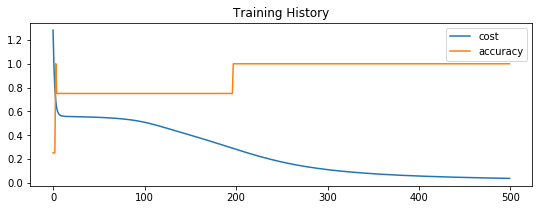

In [9]:
# AND with an extra hidden layer
nn = init_layers(seed, [
    {"input_dim": 2, "output_dim": 2, "activation": "sigmoid"},
    {"input_dim": 2, "output_dim": 2, "activation": "sigmoid"},
    {"input_dim": 2, "output_dim": 1, "activation": "sigmoid"},
])
X = np.array([[0.0,0.0],[0.0,1.0],[1.0,0.0],[1.0,1.0]]).T
Y = np.array([[0.0],[0.0],[0.0],[1.0]]).T
epochs = 500
learning_rate = 0.5
train_and_check(X,Y,nn,epochs,learning_rate)

Test Predict:
X = [[0. 0. 1. 1.]
 [0. 1. 0. 1.]]
Y_predict = (array([[0., 1., 1., 0.]]), array([[0.0576547 , 0.92365849, 0.95108652, 0.04862195]]))


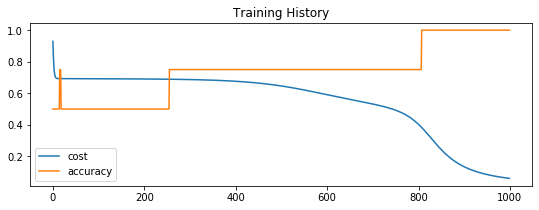

In [10]:
# XOR with an extra hidden layer
nn = init_layers(seed, [
    {"input_dim": 2, "output_dim": 2, "activation": "sigmoid"},
    {"input_dim": 2, "output_dim": 2, "activation": "sigmoid"},
    {"input_dim": 2, "output_dim": 1, "activation": "sigmoid"},
])
X = np.array([[0.0,0.0],[0.0,1.0],[1.0,0.0],[1.0,1.0]]).T
Y = np.array([[0.0],[1.0],[1.0],[0.0]]).T
epochs = 1000
train_and_check(X,Y,nn,epochs,learning_rate)